# Optimization

## Import libraries

In [153]:
# Default libraries
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import tqdm
import copy
from tqdm import tqdm

# Custom libraries
import Functions.data_tools as data_tools
from Functions.temple_data import TempleData
from Functions.artifact_removal_tool import ART
from Functions import eeg_quality_index as eqi
from Functions import optimization as optimization

# Jupyter magic to automatically reload modules when they have changed
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

In [198]:
# file = r"Data\Temple\edf\01_tcp_ar\072\00007229\s001_2010_11_02\00007229_s001_t000.edf"

file = r"/home/araz/Downloads/Araz/edf/01_tcp_ar/002/00000254/s005_2010_11_15/00000254_s005_t000.edf"
# file = r"/home/araz/Downloads/Araz/edf/01_tcp_ar/004/00000458/s004_2003_02_12/00000458_s004_t001.edf"

# file = r"Data\Temple\edf\01_tcp_ar\002\00000254\s005_2010_11_15\00000254_s005_t000.edf" # NO artifacts
# file = r"Data\Temple\edf\01_tcp_ar\002\00000254\s005_2010_11_15\00000254_s005_t000.edf" # With artifacts
temple = TempleData(file)

Extracting EDF parameters from /home/araz/Downloads/Araz/edf/01_tcp_ar/002/00000254/s005_2010_11_15/00000254_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


## Get artifacts and clean data

In [199]:
# Settings
artifact_type = "eyem"
window_length = 2

# Get artifacts
# artifacts_file = fr"Data\\Temple\\csv\\labels_{temple.montage_type}.csv"
artifacts_file = fr"/home/araz/Downloads/Araz/csv/labels_{temple.montage_type}.csv"
temple.get_artifacts_from_csv(artifacts_file)
[artifacts_chans, eyem_artifacts] = temple.get_artifact_type_data(
    artifact_type = artifact_type,
    window_length = window_length,
)

# Get clean data
clean = temple.get_clean_data(window_length)
# clean_avg = np.mean(clean, axis=0) * clean.shape[0]
clean_avg = clean[10,:,:]

Extracting artifact type: eyem


## Single run example

In [200]:
# Settings
# - Temple data
artifact_type = "eyem"  # Type of artifact to process
test_percentage = 20    # Percentage of artifact to use as test [\%]
split_seed = 42         # Seed for reproducibility
window_length = 3       # Length of window data [sec]

window_samples = int(window_length * temple.srate)

# - Optimization
x0 = (5, 1, 0.018)
n_clusters = slice(1, 6, 1)
fd_threshold = slice(1, 3, 0.2)
ssa_threshold = slice(0.005, 0.02, 0.005)

# Get artifacts
# artifacts_file = fr"Data\\Temple\\csv\\labels_{temple.montage_type}.csv"
artifacts_file = fr"/home/araz/Downloads/Araz/csv/labels_{temple.montage_type}.csv"
temple.get_artifacts_from_csv(artifacts_file)
[artifacts_chans, artifacts_data] = temple.get_artifact_type_data(
    artifact_type = artifact_type,
    window_length = window_length,
    )

# Get clean data
clean = temple.get_clean_data(window_length)
# clean_avg = np.mean(clean, axis=0) * clean.shape[0]
clean_avg = clean[10,:,:]

# Separate optimization and test sets
[i_optim, i_test] = data_tools.split_list(
    lst = list(artifacts_chans),
    test_percentage = test_percentage,
    seed = split_seed
    )

# Creat artifact removal
art = ART(
    window_length = window_length,  
    n_clusters = x0[0],
    fd_threshold = x0[1],
    ssa_threshold = x0[2] 
)

# Create EEG Quality index
eqi_total = np.zeros(artifacts_data.shape[:2])

# for (a, artifact) in enumerate(artifacts_chans):
#     for (c, chan) in enumerate(artifact):
#         subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]
#         test_eeg = art.remove_artifacts(
#             eyem_artifacts[a,c,:],
#             srate = temple.srate
#             )
    
#         eqi_total[a,:] = eqi.scoring(
#             clean_eeg = clean_avg[subset_chans,:],
#             test_eeg = test_eeg,
#             srate_clean = temple.srate,
#             srate_test = temple.srate,
#             window = int(window_samples // 10),
#             slide = int(window_samples // 20)
#         )[0]  

for (a, artifact) in enumerate(artifacts_chans):
    print(f"Artifact {a}")
    subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]
    test_eeg = art.remove_artifacts(
        artifacts_data[a,:,:],
        srate = temple.srate
        )

    eqi_total[a,:] = eqi.scoring(
        clean_eeg = clean_avg[subset_chans,:],
        test_eeg = test_eeg,
        srate_clean = temple.srate,
        srate_test = temple.srate,
        window = int(window_samples // 10),
        slide = int(window_samples // 20)
    )[0]  

    a = 0

Extracting artifact type: eyem
Artifact 0
Artifact 1
Artifact 2


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")


In [201]:
eqi_total

array([[0.        , 5.26315789, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 5.26315789,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

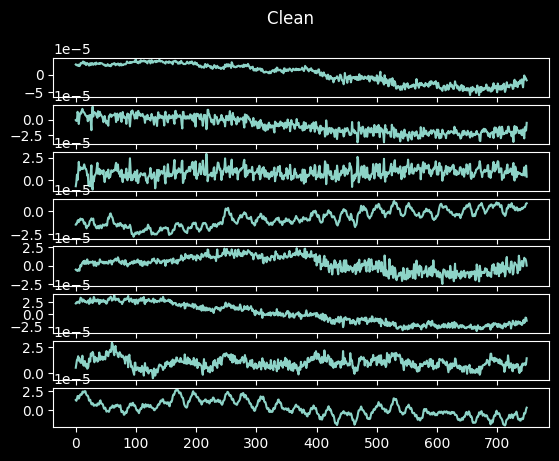

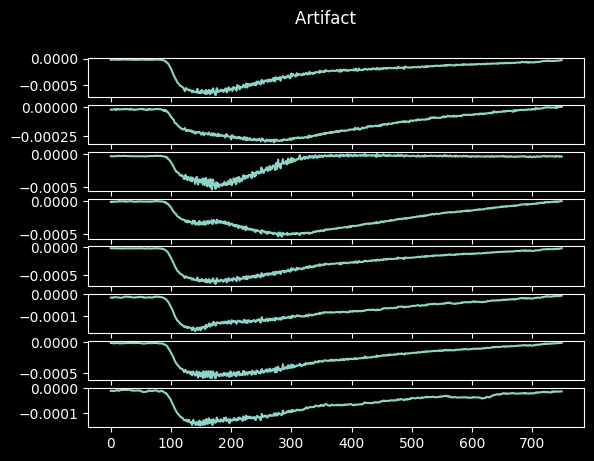

In [202]:
fig, ax = plt.subplots(len(subset_chans))
fig.suptitle("Clean ")
for c,chan in enumerate(subset_chans):
    ax[c].plot(clean_avg[c,:])

fig, ax = plt.subplots(len(subset_chans))
fig.suptitle("Artifact ")
for c,chan in enumerate(subset_chans):
    ax[c].plot(artifacts_data[2,c,:])

    

## Optimization example

In [51]:
# Settings
# - Temple data
artifact_type = "eyem"  # Type of artifact to process
test_percentage = 20    # Percentage of artifact to use as test [\%]
split_seed = 42         # Seed for reproducibility
window_length = 5       # Length of window data [sec]

window_samples = int(window_length * temple.srate)

# - Optimization parameters
n_clusters = (1, 10)
fd_threshold = (0.1, 5)
ssa_threshold = (0.001, 0.1)

# n_clusters = slice(1, 6, 1)
# fd_threshold = slice(1, 3, 0.2)
# ssa_threshold = slice(0.005, 0.02, 0.005)

# Get artifacts
# artifacts_file = fr"Data\\Temple\\csv\\labels_{temple.montage_type}.csv"
artifacts_file = fr"/home/araz/Downloads/Araz/csv/labels_{temple.montage_type}.csv"
temple.get_artifacts_from_csv(artifacts_file)
[artifacts_chans, artifacts_data] = temple.get_artifact_type_data(
    artifact_type = artifact_type,
    window_length = window_length,
    )

# Get clean data
clean = temple.get_clean_data(window_length)
clean_avg = clean[10,:,:]
# clean_avg = np.mean(clean, axis=0) * clean.shape[0]

# Optimize ART parameters
for a,artifact in enumerate(artifacts_chans):
    # Get subset of channels based on artifact
    subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]

    x0 = (5, 1, 0.018)
    bounds = (n_clusters, fd_threshold, ssa_threshold)
    args = (
        clean_avg[subset_chans,:],
        artifacts_data[a,:,:], 
        temple.srate,
        window_length
        )
    res = optimize.minimize(
        optimization.maximize_eqi,
        x0 = x0,
        bounds = bounds,
        args = args,
        method = "CG",
        callback = lambda:print("Running"),
        tol = 1e-20,
        options = {
            "maxiter": 100
        }
    )

Extracting artifact type: eyem
 EQI value 99.34210526315789


/home/araz/anaconda3/envs/art-eqi/lib/python3.11/site-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method CG cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


 EQI value 99.34210526315789
 EQI value 99.34210526315789
 EQI value 99.34210526315789


In [52]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 99.34210526315789
       x: [ 5.000e+00  1.000e+00  1.800e-02]
     nit: 0
     jac: [ 0.000e+00  0.000e+00  0.000e+00]
    nfev: 4
    njev: 1

## Brute force optimization

Test different starting points and check the fun value

In [ ]:
np.arange(0.005, 0.5, 0.1).shape

In [ ]:
for a,artifact in enumerate(artifacts_chans):
    # Get subset of channels based on artifact
    subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]

    n_clusters = slice(1, 10, 1)
    fd_threshold = slice(0.1, 5, 1)
    ssa_threshold = slice(0.005, 0.5, 0.01)
    ranges = (n_clusters, fd_threshold, ssa_threshold)
    
    args = (
        clean_avg[subset_chans,:],
        artifacts_data[a,:,:], 
        temple.srate,
        window_length
        )
    
    res_brute = optimize.brute(
        optimization.maximize_eqi,
        ranges = ranges,
        args = args
    )
    

## Greedy search

In [203]:
artifacts_chans

[['FP1-F7', 'F7-T3', 'FP2-F8', 'F8-T4', 'FP1-F3', 'F3-C3', 'FP2-F4', 'F4-C4'],
 ['FP1-F7', 'F7-T3', 'FP2-F8', 'F8-T4', 'FP1-F3', 'F3-C3', 'FP2-F4', 'F4-C4'],
 ['FP1-F7', 'F7-T3', 'FP2-F8', 'F8-T4', 'FP1-F3', 'F3-C3', 'FP2-F4', 'F4-C4']]

In [224]:
from tqdm import tqdm

# Configurables
max_stag_count = 20 # maximum number of iterations where x_err hasn't changed
max_iter = 500 # maximum number of iterations
x_err_tol = 0.1

window_length = 1

n_clusters = (1, 10)
fd_threshold = (0.1, 10)
ssa_threshold = (0.001, 0.1)
bounds = (n_clusters, fd_threshold, ssa_threshold)

def generate_candidate(bounds=bounds):
    x = [(np.random.uniform(bounds[d][0], bounds[d][1])) for d in range(len(bounds))]
    costs = []
    for a,artifact in enumerate(artifacts_chans):
        # Get subset of channels based on artifact
        subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]
        args = (
            clean_avg[subset_chans,:],
            artifacts_data[a,:,:], 
            temple.srate,
            window_length
        )
        costs.append(optimization.maximize_eqi(x, *args))
    return x, np.mean(costs)

def generate_neighboring_candidate(x, MR=0.5):
    x_new = copy.deepcopy(x)
    for i in range(len(x)):
        if np.random.uniform(0, 1) < MR:
            x_new[i] = np.random.uniform(bounds[i][0], bounds[i][1])
    costs = []
    for a,artifact in enumerate(artifacts_chans):
        # Get subset of channels based on artifact
        subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]
        args = (
            clean_avg[subset_chans,:],
            artifacts_data[a,:,:], 
            temple.srate,
            window_length
        )
        costs.append(optimization.maximize_eqi(x_new, *args))
    return x_new, np.mean(costs)

x, x_err = generate_candidate() # generate a random x (particle/candidate) and its error (cost/objective/fitness function value)
x_best = x.copy() # best solution found so far
x_best_err = x_err # best error for that solution

prev_x_err = x_err # previous iteration's x_err
stag_count = 0 # number of iterations where x_err hasn't changed
max_stag_count = max_stag_count # generate a new starting candidate if x_err hasn't changed for max_stag_count iterations

# Stopping conditions
max_iter = max_iter # maximum number of iterations
x_err_tol = x_err_tol # stop searching for a better solution when x_err < x_err_tol

pbar = tqdm() # progress bar
try:
    while abs(x_best_err) > x_err_tol and pbar.n < max_iter:

        pbar.set_description(f'x_best_err: {x_best_err:.4f}')
        pbar.update(1)

        prev_x_err = x_err
        stag_count = stag_count + 1 if prev_x_err == x_err else 0
        
        # Generate a random neighbor of x and calculate its error
        if stag_count > max_stag_count:
            x_new, x_new_err = generate_candidate()
            stag_count = 0
        else:
            x_new, x_new_err = copy.deepcopy(x), x_err
            x_new, x_new_err = generate_neighboring_candidate(x_new)

        # Update x and x_err if the new solution is better
        if x_new_err < x_err:
            x, x_err = x_new, x_new_err # if x_new is better, update x and x_err
            if x_err < x_best_err:
                x_best, x_best_err = x, x_err # if x_new is the best, update x_best and x_best_err

except KeyboardInterrupt:
    pass
finally:
    pbar.close()

print(f'x: {x}, x_err: {x_err}, x_best: {x_best}, x_best_err: {x_best_err}')

x_best_err: 98.9071: : 0it [00:00, ?it/s]

x_best_err: 98.9071: : 500it [00:06, 76.38it/s]

x: [9.686982920471522, 0.3054839127248031, 0.03489140868993834], x_err: 98.90710382513662, x_best: [9.686982920471522, 0.3054839127248031, 0.03489140868993834], x_best_err: 98.90710382513662


## Differential evolution optimization

In [139]:
for a,artifact in enumerate(artifacts_chans):
    # Get subset of channels based on artifact
    subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]

    n_clusters = (1, 10)
    fd_threshold = (0.1, 10)
    ssa_threshold = (0.001, 0.1)
    bounds = (n_clusters, fd_threshold, ssa_threshold)
    
    optimization_results = []

    args = (
        clean_avg[subset_chans,:],
        artifacts_data[a,:,:], 
        temple.srate,
        window_length
        )
    
    res_diff = optimize.differential_evolution(
        optimization.maximize_eqi,
        bounds = bounds,
        args = args,
        polish = True,
        callback = lambda intermediate_result, **kwargs: optimization_results.append(intermediate_result),
    )

/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
/home/araz/Documents/GitHub/art-eqi-p300-validation/Functions/eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


KeyboardInterrupt: 

In [142]:
res_diff

 message: Optimization terminated successfully.
 success: True
     fun: 99.34210526315789
       x: [ 9.234e+00  8.606e-01  4.185e-02]
     nit: 1
    nfev: 94

In [56]:
optimization_results[1].keys()

IndexError: list index out of range

In [57]:
for iteration in optimization_results:
    nit = iteration["nit"]
    fun = iteration["fun"]
    message = iteration["message"]
    print(f"{message} {nit}: {fun}")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices